# Airbnb Pricing Analysis

### Notebook By: Mike Li

# SUMMARY

## Project Goal

The goal of this project is to build a model to predict the rental prices of AirBNB listings based on various factors such as location, size, etc 

## Data Wrangling

1. Transform Date columns (host_since, first_review, last_review) to date Format

2. Transform dollar amount columns (price, weekly_price, monthly_price, security_deposit, cleaning_fee):
    a) removing $ and "," signs
    b) filling the empty dollar values with 0

3. Transform some columns with discrete values to type "category". These are property_type, room_type, bed_type, cancellation_policy

4. Run drop_duplicates() on dataframe to remove duplicates.

### Initial Review
1. Total Record Count: 7785<BR>
2. NULL Columns (ie with missing values):<BR>
|**Columns|Values Count**|<BR>
|bathrooms|7778|<BR>
|bedrooms|7784|<BR>
|square_feet|217|<BR>
|weekly_price|1302|<BR>
|monthly_price|1012|<BR>
|security_deposit|5563|<BR>
|cleaning_fee|6782|<BR>
|first_review|6724|<BR>
|last_review|6731|<BR>

## Exploratory Data Analysis (EDA)

**The analysis will mainly use these information:**
1. The rental configurations (property type, room type, bathrooms, bedrooms, square_feet, etc)
2. pricing (price, weekly_price, monthly_price, security_deposit, cleaning_fee) -> Discount (derived)
3. host's policy (guests_included, extra_people, minimum_nights, maximum_nights, cancellation_policy)
4. host (host_is_superhost)
5. Airbnb reviews (number_of_reviews,first_review, last_review)

# Actual Notebook

In [79]:
# IMPORTs and CONSTANTs
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.basemap import Basemap, cm
import seaborn as sns

# 9/28/18: current city, state, etc are used in EDA to assign scores for host_location
CURR_CITY = 'Seattle'
CURR_STATE = 'Washington'
CURR_COUNTRY = 'United States'

In [80]:
#r_listings = pd.read_csv('sea_first100.csv', index_col='id');
r_listings_raw = pd.read_csv('20180816_listings.csv', index_col='id');

/Users/mikeli888/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [81]:
print(r_listings_raw.shape)
r_listings_raw.head(2)

(8494, 95)


,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
2318,https://www.airbnb.com/rooms/2318,20180816121209,2018-08-16,"Casa Madrona - Urban Oasis, 1 block from the P...","Gorgeous, architect remodeled, 1917 Dutch Colo...","Casa Madrona is a gorgeous, architect remodele...","Gorgeous, architect remodeled, 1917 Dutch Colo...",none,NaN,"We adhere to a 10pm -9am quiet hour schedule, ...",...,f,NaN,{WASHINGTON},t,f,strict_14_with_grace_period,f,f,2,0.16
4291,https://www.airbnb.com/rooms/4291,20180816121209,2018-08-16,Sunrise in Seattle Master Suite,This property is located in the lovely Maple L...,"Located in Seattle, this is a spacious, clean ...",This property is located in the lovely Maple L...,none,NaN,NaN,...,f,NaN,{WASHINGTON},f,f,moderate,f,f,5,0.91


In [82]:
# TODO: General (Ref Unit 7.1.2 video)
# 1) What's the story?
# 2) What's memorable example of this? (ref: Linda the Bank Teller) (6/30)
# 3) What're more questions this will raise?
# 4a) Who is your audience? (but should be accessible to broadest audiences possible)
# 4b) What questions are you answering?
# 4c) Why should the audience care?
# 4d) What are your major insights and surprises? What change to you want to affect?

# 1) Story: Being an Airbnb host is not easy. Besides dealing with changing local 
#            regulations on the rental and uncertainty of renting out your house, 
#            the host also needs to ensure there is profit after incurring all the costs. 
# 4a) Audience: Airbnb hosts
# 4b) Questions Answering:
#     1) What drives price? Loc (eg Zips) or Configs (bed_type, room_type, property_type)    
# 4c) Why they care: Help them maximize profit by optimize the rental price, weekly and monthly prices


## Data Cleaning

### Initial Review: List columns with Null values

In [83]:
# Initial Review
# 1) Extract Subset of columns we will use for analysis 
# 9/8/18: Included amenities, neighbourhood_cleansed, neighbourhood_group_cleansed
# 9/27/18: break to different sets of columns based on attribute types (eg features, policy, host, reviews)

basic_data = [
'city', 'state', 'zipcode',
'latitude','longitude',
'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
'price','weekly_price','monthly_price',
'guests_included','extra_people']

features_data = ['price', 'property_type','room_type','accommodates','bathrooms','bedrooms','beds', 'amenities','bed_type','square_feet']

policy_data = ['price', 'security_deposit', 'cleaning_fee', 'minimum_nights','maximum_nights', 'cancellation_policy']
    
host_data = ['price', 'host_since', 'host_is_superhost', 'host_location', 'host_response_time', 'host_response_rate', 'host_listings_count', 'host_has_profile_pic', 'host_identity_verified']

reviews_data = ['price', 'number_of_reviews', 'first_review', 'last_review',
'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
'review_scores_value', 'reviews_per_month']

required_data = list(set(basic_data)| set(features_data) | set(policy_data) | set(host_data)| set(reviews_data))

r_listings = r_listings_raw[:][required_data]
print(r_listings.shape)
r_listings.info()

(8494, 45)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8494 entries, 2318 to 27789514
Data columns (total 45 columns):
number_of_reviews               8494 non-null int64
extra_people                    8494 non-null object
price                           8494 non-null object
bed_type                        8494 non-null object
review_scores_communication     7463 non-null float64
security_deposit                6395 non-null object
guests_included                 8494 non-null int64
host_identity_verified          8494 non-null object
last_review                     7532 non-null object
host_since                      8494 non-null object
amenities                       8494 non-null object
longitude                       8494 non-null float64
review_scores_location          7461 non-null float64
neighbourhood_cleansed          8494 non-null object
property_type                   8494 non-null object
review_scores_checkin           7460 non-null float64
latitude                 

### Initial Review: Visual review of Categorical Data (eg property/room/bed types) for bad values

In [84]:
# Review: Categories data
print("property_type")
print(r_listings['property_type'].value_counts(dropna=False))
print("\nroom_type")
print(r_listings['room_type'].value_counts(dropna=False))
print("\nbed_type")
print(r_listings['bed_type'].value_counts(dropna=False))

property_type
House                     3037
Apartment                 2934
Townhouse                  689
Guest suite                612
Condominium                409
Guesthouse                 204
Serviced apartment         115
Bungalow                   107
Loft                       103
Aparthotel                  40
Bed and breakfast           39
Other                       37
Cottage                     36
Boat                        23
Camper/RV                   18
Houseboat                   18
Tiny house                  17
Cabin                       16
Tent                        10
Hostel                       8
In-law                       3
Resort                       3
Villa                        3
Boutique hotel               2
Yurt                         2
Treehouse                    1
Bus                          1
Hut                          1
Castle                       1
Nature lodge                 1
Lighthouse                   1
Earth house              

### Data Cleaning of Numeric Data

In [85]:
# Numeric Columns
# 1) Remove $ sign for columns 
# 2) Fill Null values with 0
# Ref: Cleaning Data (UNIT 5.1.4_ Using regular expressions to clean string)

def remove_sign(amt):
   amt = amt.replace('$', '').replace(',','')
   return(float(amt))

# TODO: 7/3/18:
# 1) just use groupby by zipcode to use mean(), etc. (Make sure blank is NaN and no String values)

# Fill null values with 0
r_listings['price'] = r_listings['price'].fillna('0') 
r_listings['weekly_price'] = r_listings['weekly_price'].fillna('0') 
r_listings['monthly_price'] = r_listings['monthly_price'].fillna('0') 
r_listings['security_deposit'] = r_listings['security_deposit'].fillna('0') 
r_listings['cleaning_fee'] = r_listings['cleaning_fee'].fillna('0') 

# Strip $ or "," signs from amt values
r_listings['price']  = r_listings['price'].apply(remove_sign)
r_listings['weekly_price']  = r_listings['weekly_price'].apply(remove_sign)
r_listings['monthly_price']  = r_listings['monthly_price'].apply(remove_sign)
r_listings['security_deposit']  = r_listings['security_deposit'].apply(remove_sign)
r_listings['cleaning_fee']  = r_listings['cleaning_fee'].apply(remove_sign)

### Visual review of Numeric Data for Outliers

In [86]:
# Review: Numeric data
print('Summary of price')
print(r_listings['price'].describe())

# print("\nMore Bathrooms than bedrooms")

Summary of price
count    8494.000000
mean      152.532494
std       137.133373
min         0.000000
25%        80.000000
50%       119.000000
75%       189.000000
max      5400.000000
Name: price, dtype: float64


### Cleaning and tidying datetime data

In [87]:
# Ref 5.1.1
# 6/26/18: Parse Date columns
r_listings['host_since'] = pd.to_datetime(r_listings['host_since'])
r_listings['first_review'] = pd.to_datetime(r_listings['first_review'])
r_listings['last_review'] = pd.to_datetime(r_listings['last_review'])

In [88]:
# TODO: Cleaning numeric data (Ref: 5.1.1)
# 1) Identify columns should be numeric, use dtypes() after load; if type is "object" -> non-numeric values in data
# 2) Use pd.to_numeric(), ref: "Cleaining Numberic column" exercise
#    a) Also Unit 5.1.4 start, use para errors='coerce' (turn bad values to "NaN")


### Parse amenities column to a feature matrix for analysis

In [89]:
r_listings['amenities'] = r_listings['amenities'].map(
    lambda amns: "|".join([amn.replace("}", "").replace("{", "").replace('"', "")\
                           for amn in amns.split(",")])
)
r_listings['amenities'].head(5)

id
2318    Internet|Wifi|Kitchen|Free parking on premises...
4291    TV|Cable TV|Internet|Wifi|Free parking on prem...
5682    TV|Internet|Wifi|Free street parking|Heating|F...
6606    TV|Cable TV|Internet|Wifi|Kitchen|Free parking...
9419    Internet|Wifi|Air conditioning|Kitchen|Free pa...
Name: amenities, dtype: object

In [90]:
# 9/8/18: [1:] is to remove the 1st empty array from the list
r_listings['amenities_array'] = r_listings['amenities'].map(lambda amns: amns.split("|"))[1:]

### Transform Categorical Data

In [91]:
# TODO: Misc Cleaning (6/29/18)
# 0) Use count() to review columns that have NULL data
# 1) Identify columns that should be Categorical, then change the dtype
#    eg tips.smoker = tips.smoker.astype('category')
# 2) Identify columns with Missing Data
# 3) Run df.drop_duplicates() to ensure no dups
# 4) MIssing Data: If needed, (ref: Unit 5.1.4 chap4)
#    a) use tips_nan.dropna() to drop them or 
#    b) fillna() to fill them

# TODO (7/3/18): 
#    1) convert the type values to numeric values so modeling like random forest; etc
#    2) Linear Regression: Can't pass number; one hot encoding / dummy variables.

# 1) Identify columns that should be Categorical, then change the dtype
# columns: property_type, room_type, bed_type, cancellation_policy
r_listings['property_type'] = r_listings['property_type'].astype('category')
r_listings['room_type'] = r_listings['room_type'].astype('category')
r_listings['bed_type'] = r_listings['bed_type'].astype('category')
r_listings['cancellation_policy'] = r_listings['cancellation_policy'].astype('category')

# 8/17/18: Remove invalid zip codes
r_listings['zipcode'] = pd.to_numeric(r_listings['zipcode'], errors='coerce')
r_listings = r_listings.dropna(subset=['zipcode'])
r_listings['zipcode'] = r_listings['zipcode'].astype('int')

#r_listings.drop_duplicates() 
#print("Dropped Duplicates")  # 7/24/18: drop_duplicates() somehow lists out whole dataframe

### Drop Outliers

#### Approach: 
1) Set a specific price point $1650 and listings above that price is considered outliers

In [92]:
# 8/3/18: Removed few outliers that are over $2000
# 8/18/18: There are 2 more outliers with $1650 and $1750, lower price threshold to below $1650
r_cleaned = r_listings[r_listings['price'] < 1650]

In [93]:
r_cleaned[r_cleaned['price'] >= 1650][['property_type','price','bedrooms','bathrooms']]

,property_type,price,bedrooms,bathrooms
id,,,,


##   Exploratory Data Analysis (EDA) 

## Overview:
1) My audiences are the homeowners who are deciding 
* if they can make profit listing the house in AirBNB and 
* best listing price to optimize their profit while to ensure the unit will be leased in reasonable time.

2) The analysis will be based on the Supply-side data (AirBNB listings) at the moment to determine the right market price for a specific property

## Initial Statistics: 

In [94]:
print(r_cleaned['price'].describe())

count    8417.000000
mean      150.919568
std       114.207548
min         0.000000
25%        80.000000
50%       119.000000
75%       189.000000
max      1500.000000
Name: price, dtype: float64


### ECDF of the Listing Prices
1) The ECDF plot indicates that most of Seattle listing prices (around 97.5 percentile) are $500 or below

In [95]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y

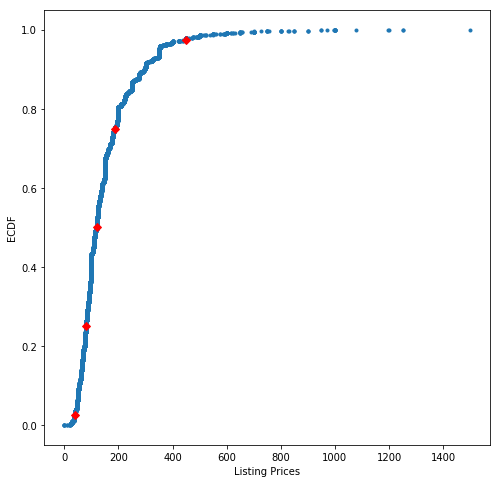

In [96]:
list_prices = r_cleaned['price']

# Compute percentiles:
percentiles = np.array([2.5, 25, 50, 75, 97.5])
ptiles_vers = np.percentile(list_prices, percentiles)

plt.rcParams["figure.figsize"] = [8, 8]

# Compute ECDF for versicolor data: x_vers, y_vers
x_vers, y_vers = ecdf(list_prices)

# Generate plot
_ = plt.plot(x_vers, y_vers, marker='.', linestyle='none')

# Overlay percentiles as red diamonds.
_ = plt.plot(ptiles_vers, percentiles/100, marker='D', color='red',
         linestyle='none')

# Label the axes
_ = plt.xlabel('Listing Prices')
_ = plt.ylabel('ECDF')

# Display the plot
plt.show()

## Analysis on any trend between number of listings and listing prices?

### Conclusion:
1) Listing prices are highly concentrated around the mean price around $150

#### Approach
1) Break down price ranges to 50 buckets<BR>
2) Build dataframe with num of listings vs average price under each price bucket<BR>
3) Plot a histogram with these data and try to identify correlations<BR>
4) Identify further questions from the analysis<BR>

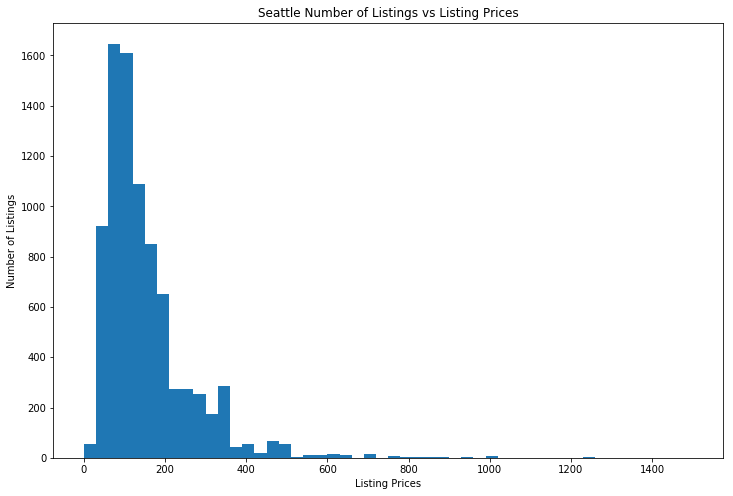

In [97]:
# ver1
list_prices = r_cleaned['price']

plt.rcParams["figure.figsize"] = [12, 8]
plt.hist(list_prices, bins = 50)
plt.title(CURR_CITY + ' Number of Listings vs Listing Prices')
plt.xlabel('Listing Prices')
plt.ylabel('Number of Listings')
plt.show()

## Analysis on the Locations

### Question: Is there any trend between locations (zipcode) and listing prices?

#### Approach
1) Build dataframe with num of listings vs average price under each price bucket<BR>
2) Plot a Bar chart with these data and try to identify correlations<BR>
3) Identify further questions from the analysis<BR>

### Initial Observations 
1) From the chart result, listing prices are in a narrow range except for a specific zip 98134
2) Zip 98122 contains the most listings while zip 98101 has the highest mean price

In [98]:
# Summary
def percent_str(row):
    return (str(row['percent_per_total'])+"%")

price_by_zips = r_cleaned.groupby('zipcode').price.mean()
weight_by_zips = round(r_cleaned.groupby('zipcode').price.count()/len(r_cleaned) *100, 3)
pricing_by_zips = pd.concat([price_by_zips, weight_by_zips], keys=['mean_price','percent_per_total'], axis=1)
pricing_by_zips['percent_str'] = pricing_by_zips.apply (lambda row: percent_str(row),axis=1)

print('Total Listings count: ', len(r_cleaned))
print("Pricing by Zips")
print(pricing_by_zips.sort_values(by='percent_per_total', ascending=0).head(10)) # sort by descending order

Total Listings count:  8417
Pricing by Zips
         mean_price  percent_per_total percent_str
zipcode                                           
98122    150.236667             10.693     10.693%
98103    137.405337              9.350       9.35%
98101    235.960854              6.677      6.677%
98109    181.980237              6.012      6.012%
98102    144.752475              6.000        6.0%
98105    115.883436              5.810       5.81%
98121    192.164557              5.631      5.631%
98144    120.120172              5.536      5.536%
98115    117.295630              4.622      4.622%
98118    129.712000              4.455      4.455%


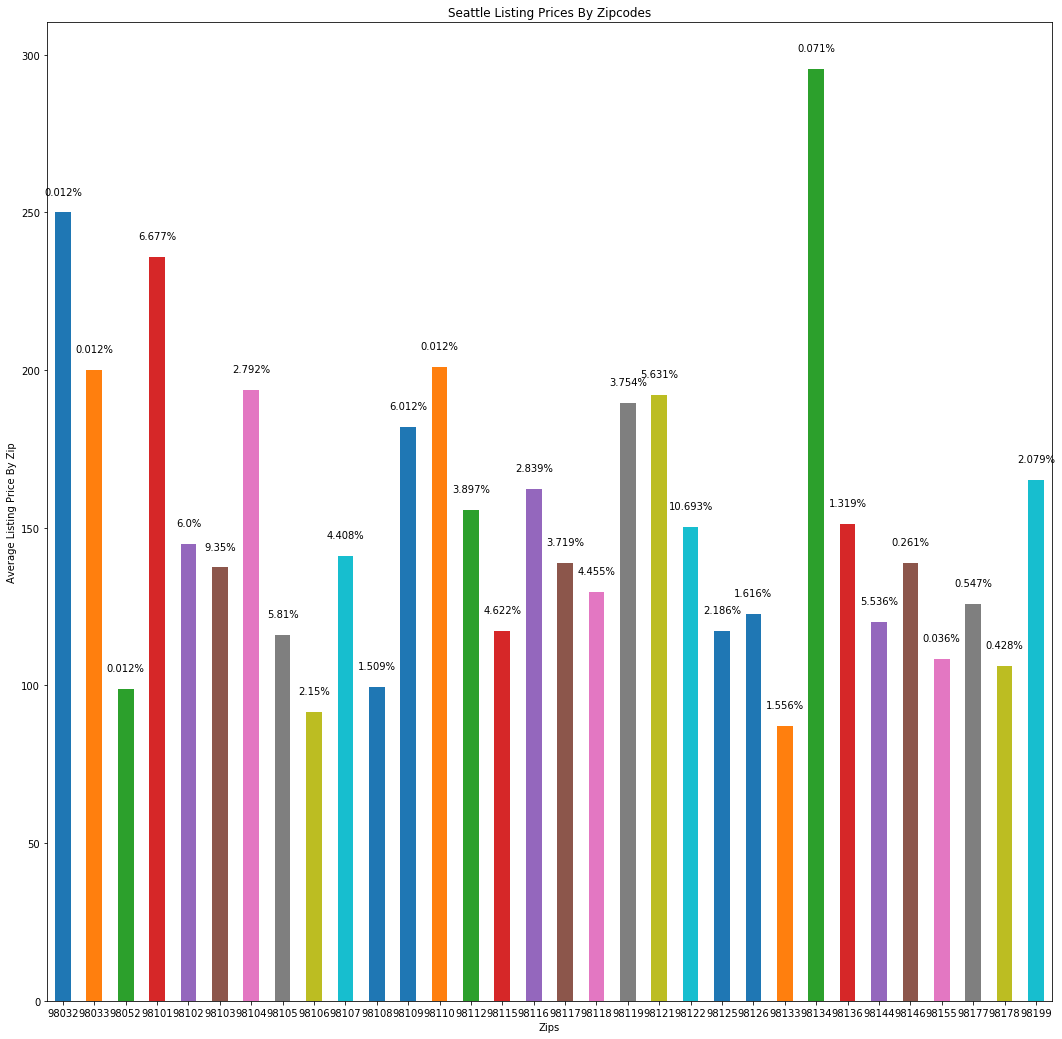

In [120]:
#price_by_zips.plot(x='zipcode', kind='bar')
plt.rcParams["figure.figsize"] = [18, 18]
bc = pricing_by_zips['mean_price'].plot.bar(rot=0)

# Add text
rects = bc.patches
labels = pricing_by_zips['percent_str']
for rect, label in zip(rects, labels):
    height = rect.get_height()
    bc.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
    
plt.xlabel('Zips')
plt.ylabel('Average Listing Price By Zip')
plt.title(CURR_CITY + ' Listing Prices By Zipcodes')
plt.show()

### Seattle AirBNB Listings Distribution
1) From below plots, we can see heavy cluster of listings around the Capitol Hill and Downtown neighborhoods.
2) The mean price goes from the highest in the Downtown neighborhood to the lowest in the Delridge neighborhood

### Seattle Neighborhood Map
<img src="Seattle_overview_v2.png">

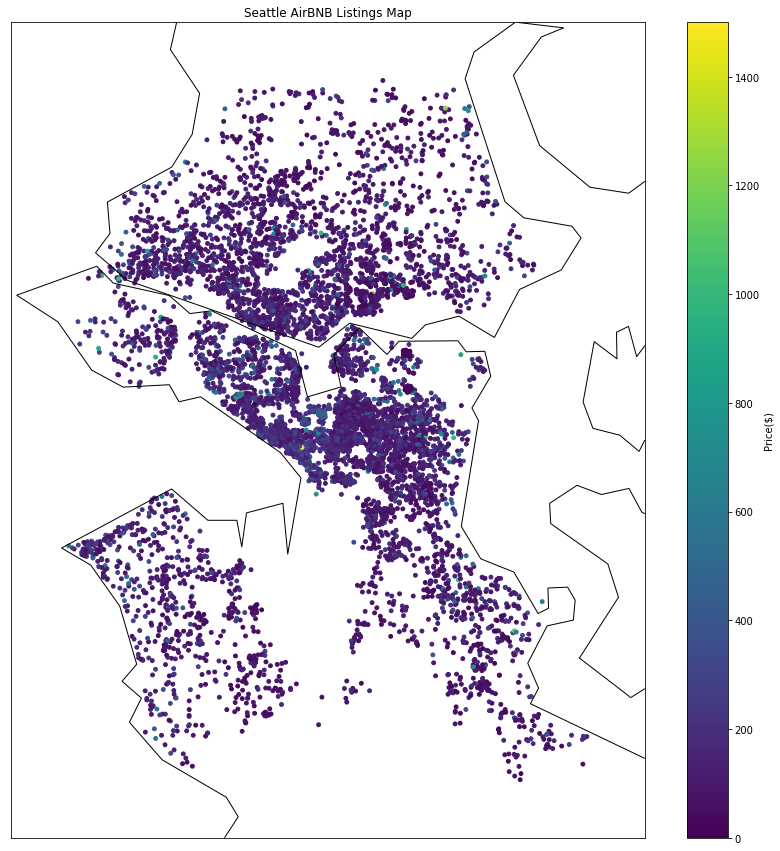

<Figure size 792x504 with 0 Axes>

In [100]:
# Map
plt.rcParams["figure.figsize"] = [15,15]

# Ref: Neighborhoods Map
# https://i.pinimg.com/originals/7c/ff/82/7cff820ca0528814d012647beec14d56.gif

##coordinates for plotting 
long_max = r_cleaned['longitude'].max() + .02
long_min = r_cleaned['longitude'].min() -.02
mid_long = (r_cleaned['longitude'].min() + r_cleaned['longitude'].max())/2

lat_max = r_cleaned['latitude'].max() + .02
lat_min = r_cleaned['latitude'].min() - .02
mid_lat = (r_cleaned['latitude'].min() + r_cleaned['latitude'].max())/2

#print(long_max, long_min, mid_long)
#print(lat_max, lat_min, mid_lat)

## map
m = Basemap(projection='cyl',lat_0=mid_lat,lon_0=mid_long,\
            llcrnrlat=lat_min,urcrnrlat=lat_max,\
            llcrnrlon=long_min,urcrnrlon=long_max,\
            rsphere=6371200.,resolution='h',area_thresh=10)
m.drawcoastlines()
m.drawstates()
#m.drawcounties()   # 9/7/18: these 2 stmts caused errors
#m.shadedrelief()

## locations
# draw 25% samples from original data set to reduce clutter in map
#x, y = m(r_cleaned['longitude'], r_cleaned['latitude'])
r_samples = r_cleaned

x, y = m(r_samples['longitude'], r_samples['latitude'])
sp = plt.scatter(x, y, c=r_samples['price'], s=15)

plt.rcParams["figure.figsize"] = [11,7]
cb = plt.colorbar(sp)
cb.set_label('Price($)')
plt.title(CURR_CITY + ' AirBNB Listings Map')

plt.show()
plt.clf()

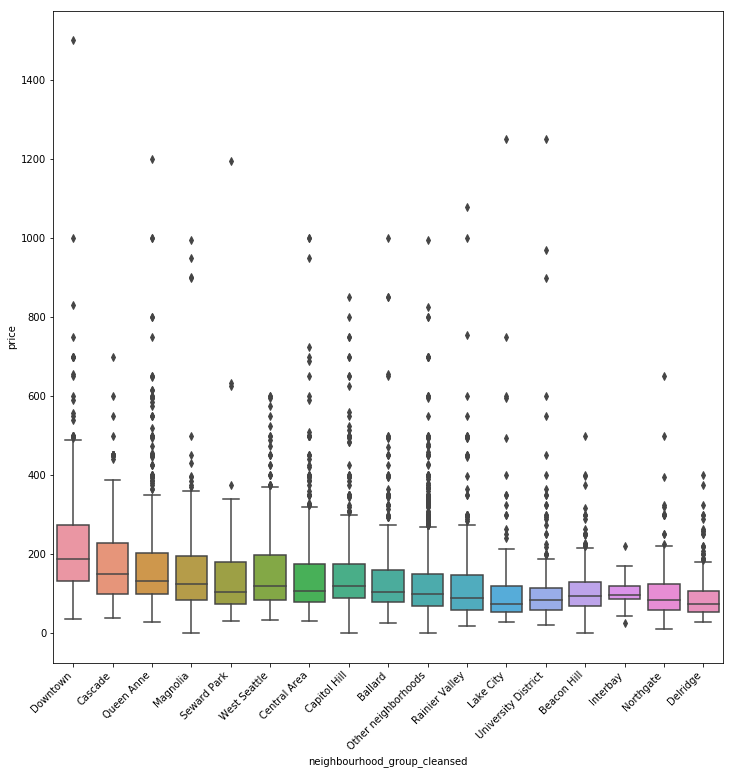

In [101]:
# Price by Neighborhood Groups
plt.rcParams["figure.figsize"] = [12,12]
sort_order = r_cleaned.groupby('neighbourhood_group_cleansed')['price']\
                    .mean()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='neighbourhood_group_cleansed', data=r_cleaned, 
            order=sort_order)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

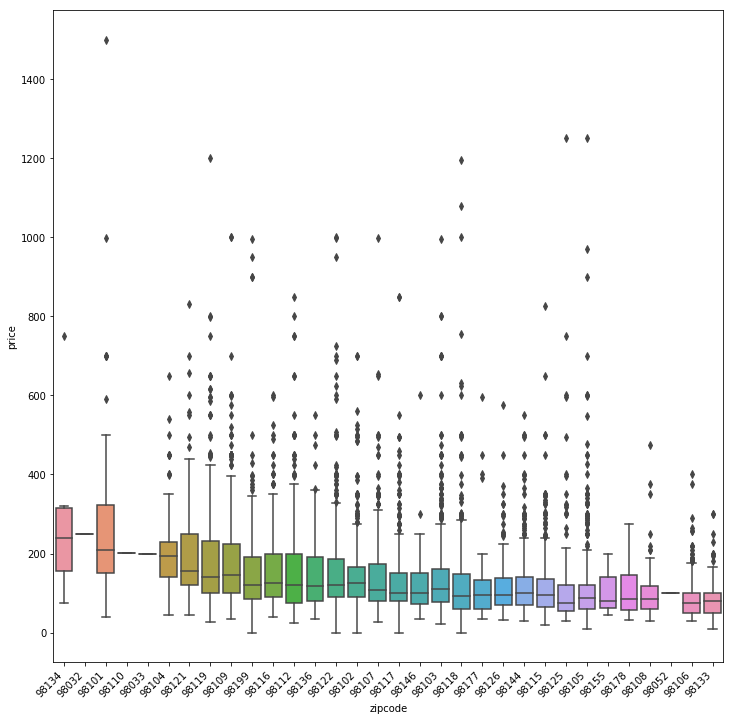

In [102]:
# Price by Zip
plt.rcParams["figure.figsize"] = [12,12]
sort_order = r_cleaned.groupby('zipcode')['price']\
                    .mean()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='zipcode', data=r_cleaned, 
            order=sort_order)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

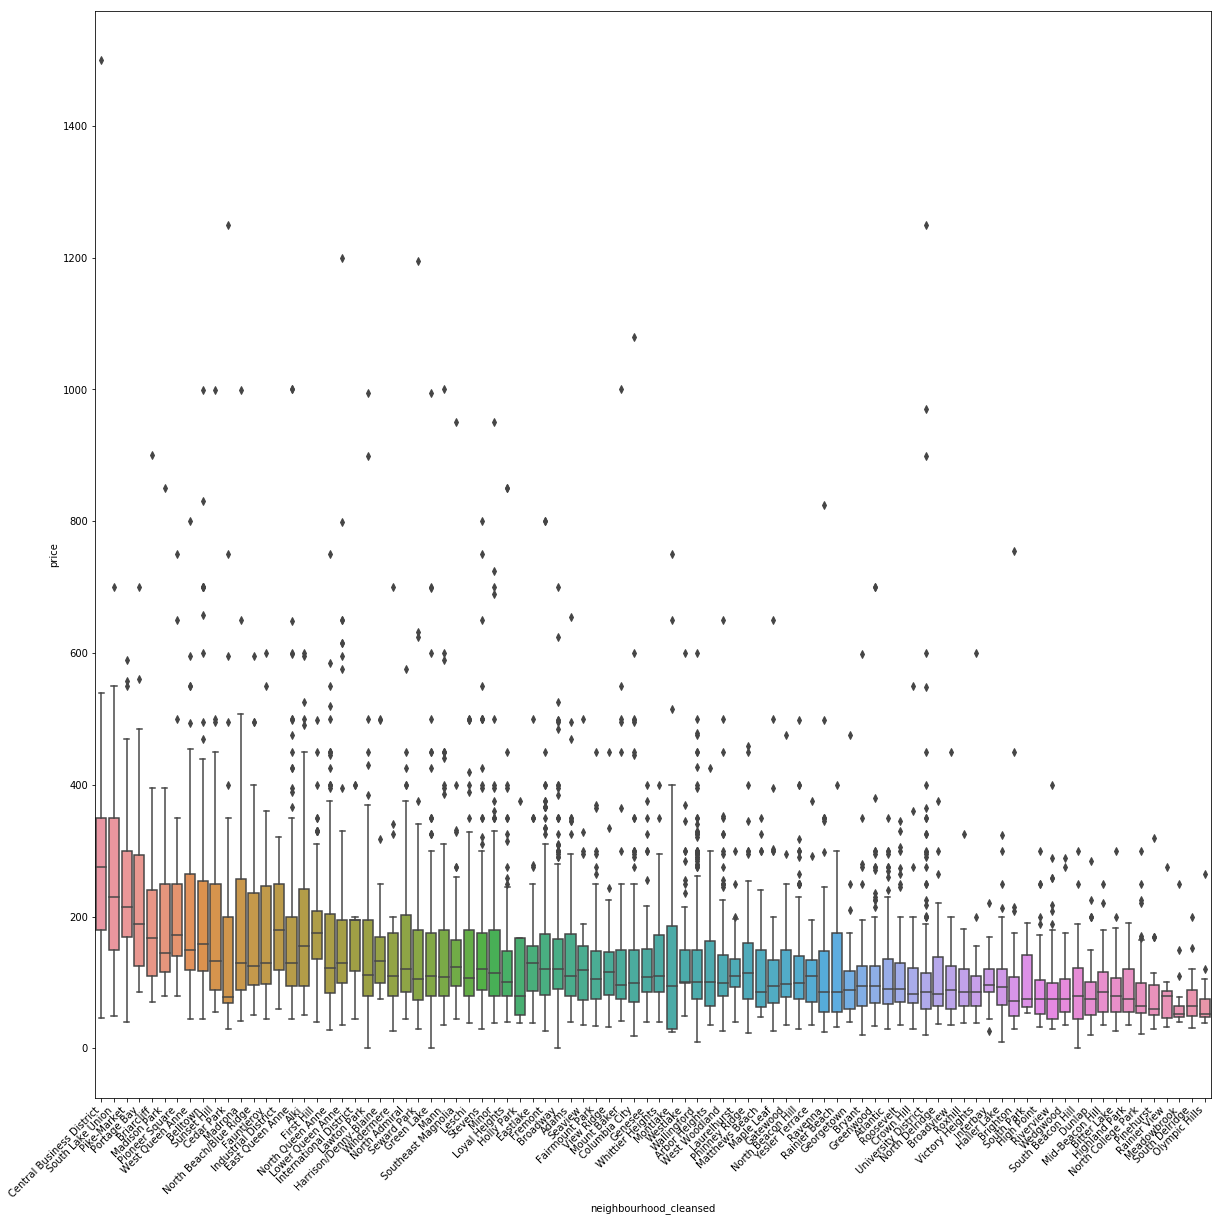

In [103]:
# Price by Neighborhoods
plt.rcParams["figure.figsize"] = [20,20]
sort_order = r_cleaned.groupby('neighbourhood_cleansed')['price']\
                    .mean()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='neighbourhood_cleansed', data=r_cleaned, 
            order=sort_order)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

#### 8/18/18: Check Zip 98134 if it's outlier
1) There are 6 entries that have reasonable listing prices under this zip, cannot considered as outlier

In [104]:
# 8/18/18: Check Zip 98134 if it's outlier
r_cleaned[r_cleaned['zipcode'] == 98134][['property_type','price','bedrooms','bathrooms']]

,property_type,price,bedrooms,bathrooms
id,,,,
789229,Apartment,149.0,1.0,1.0
2919571,Loft,320.0,2.0,1.0
16873284,Loft,180.0,2.0,1.0
21173203,Other,750.0,0.0,0.0
26131078,House,299.0,2.0,1.0
26804995,Apartment,75.0,0.0,1.0


## Analysis on the Features

### Conclusion
1) From below plot, it seems Price has higher correlations with accommodates, bedrooms and square_feet.<BR>

In [114]:
features_df = r_cleaned[:][features_data]
features_df.corr()

,price,accommodates,bathrooms,bedrooms,beds,square_feet
price,1.000000,0.594116,0.433696,0.538710,0.514003,0.525060
accommodates,0.594116,1.000000,0.531002,0.781323,0.864283,0.708531
bathrooms,0.433696,0.531002,1.000000,0.612668,0.531016,0.493908
bedrooms,0.538710,0.781323,0.612668,1.000000,0.761920,0.648296
beds,0.514003,0.864283,0.531016,0.761920,1.000000,0.384354
square_feet,0.525060,0.708531,0.493908,0.648296,0.384354,1.000000


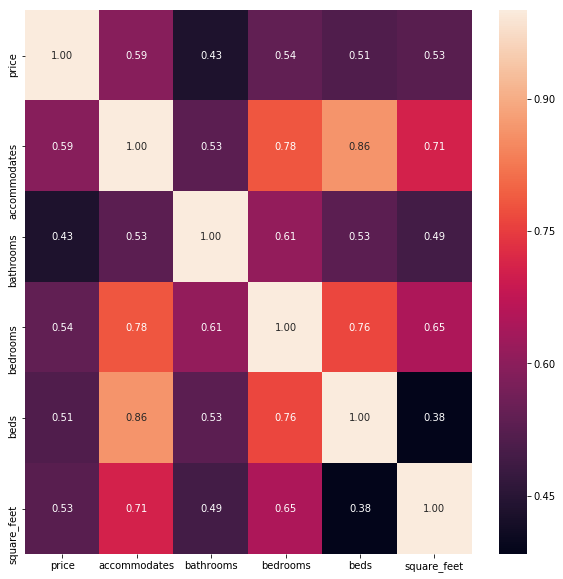

In [116]:
# Build Features Correlation
# Ref: http://www.neural.cz/dataset-exploration-boston-house-pricing.html
# Ref2: https://seaborn.pydata.org/generated/seaborn.heatmap.html
# Ref3: https://tryolabs.com/blog/2017/03/16/pandas-seaborn-a-guide-to-handle-visualize-data-elegantly/ (Closer to mine)

plt.rcParams["figure.figsize"] = [10,10]
sns.heatmap(features_df.corr(), annot=True, fmt=".2f")
plt.show()


### Question: Is there any relationships between configurations (bathrooms, bedrooms, beds) and listing prices?

### Conclusion:
1) From below plot, it seems price trends higher when number of bedrooms is 3 or more

### Analysis Details
1) Build dataframe with config_type vs the listing prices (broken in 10 price bucket)<BR>
2) Plot Scatterplots with these data and try to identify correlations (eg liner relationship)<BR>

#### Number of bedrooms and bathrooms

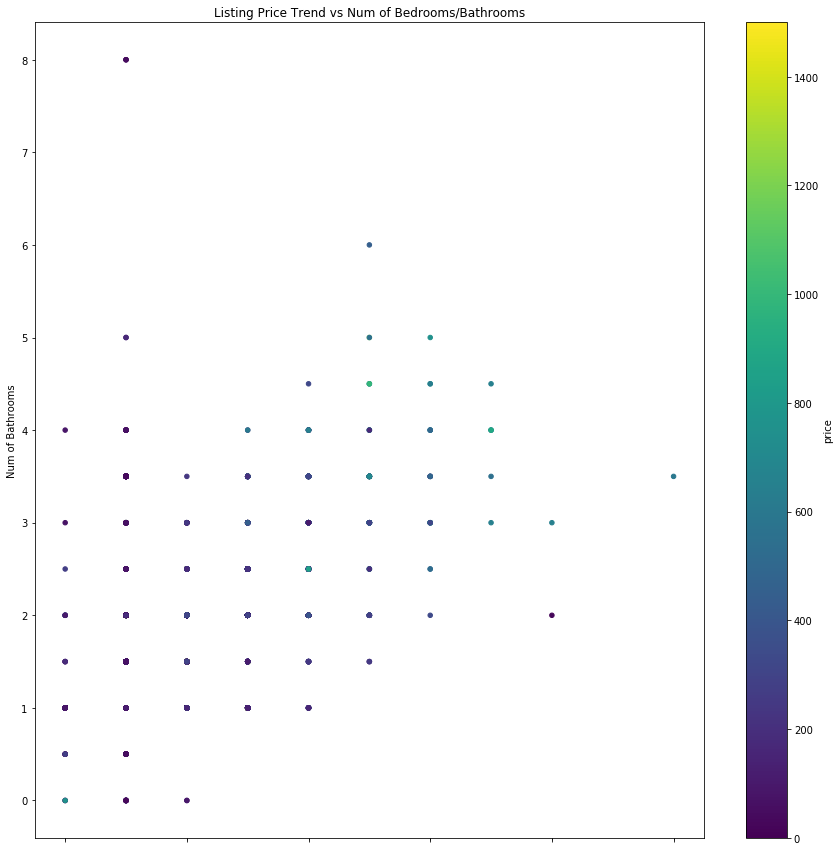

In [107]:
# Ref: Unit 5.1.2: Hierarchical.. Index (for 2-level X-axis)
# eg. stocks = stocks.set_index(['Symbol', 'Date'])

# def get_price_bucket(curr_price, size=15):
#     max_price = r_cleaned['price'].max()
#     bucket_size = max_price/size
#     bucket = int(curr_price/bucket_size)+1
#     return(bucket)

plt.rcParams["figure.figsize"] = [15, 15]
rooms_df = r_cleaned[:][['price','bedrooms','bathrooms']]
#rooms_df['price_bucket'] = rooms_df['price'].apply(get_price_bucket, size=50)
rooms_df = rooms_df.dropna()
#print(rooms_df)

# Scatter Plot
rooms_df.plot.scatter('bedrooms', 'bathrooms', c='price', cmap='viridis')
plt.xlabel('Num of Bedrooms')
plt.ylabel('Num of Bathrooms')
plt.title('Listing Price Trend vs Num of Bedrooms/Bathrooms')
plt.show()

#### Confirm the outliers data (8/18/18)
1) The Outlier with $1650 is a 3-Story Mid-century modern triplex; removed from the data set (8/18/18)

In [108]:
# Confirm the outliers price data (8/18/18)
# r_cleaned[r_cleaned['bathrooms'] == 6][['property_type','price','bedrooms','bathrooms']]

## Analysis on Policy data (eg Security Deposit and Cleaning Fee)

### Conclusion 
1) From the analysis, cleaning Fee is only policy data that seems to have impact on listing price.<BR>
2) The cleaning fee mostly varies between 0 to 300 over different levels of listing prices.<BR>

In [117]:
policy_df = r_cleaned[:][policy_data]
policy_df.corr()

,price,security_deposit,cleaning_fee,minimum_nights,maximum_nights
price,1.000000,0.292949,0.582248,0.014751,0.040795
security_deposit,0.292949,1.000000,0.414735,0.111534,0.001236
cleaning_fee,0.582248,0.414735,1.000000,0.056225,0.056962
minimum_nights,0.014751,0.111534,0.056225,1.000000,0.007729
maximum_nights,0.040795,0.001236,0.056962,0.007729,1.000000


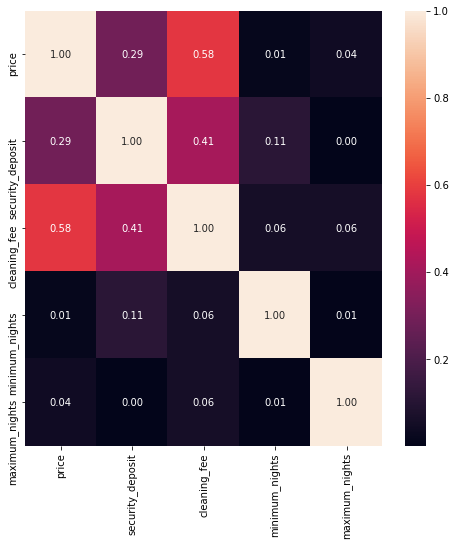

In [119]:
plt.rcParams["figure.figsize"] = [8,8]
sns.heatmap(policy_df.corr(), annot=True, fmt=".2f")
plt.show()

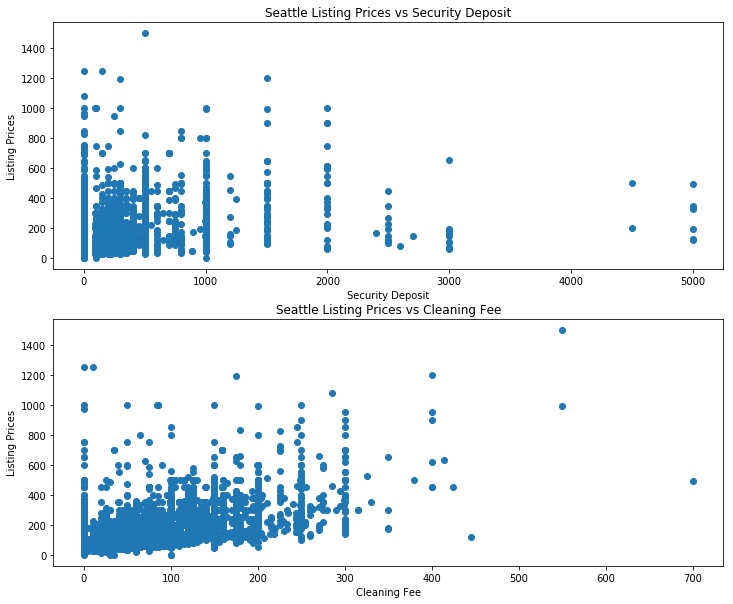

In [109]:
# ver1
list_prices = r_cleaned['price']

plt.rcParams["figure.figsize"] = [12, 10]
plt.subplot(2,1,1)
x_data = r_cleaned['security_deposit']
plt.xlabel('Security Deposit')
plt.ylabel('Listing Prices')
plt.title(CURR_CITY + ' Listing Prices vs Security Deposit')
plt.scatter(x_data, list_prices)

plt.subplot(2,1,2)
x_data = r_cleaned['cleaning_fee']
plt.xlabel('Cleaning Fee')
plt.ylabel('Listing Prices')
plt.title(CURR_CITY + ' Listing Prices vs Cleaning Fee')
plt.scatter(x_data, list_prices)

plt.show()

#### Cleaning Fee vs Bedroom/Bathrooms

#### Observations 
1) Num of Bedrooms has more impact on Cleaning Fee than num of bathrooms (based on color changes vs num of rooms)

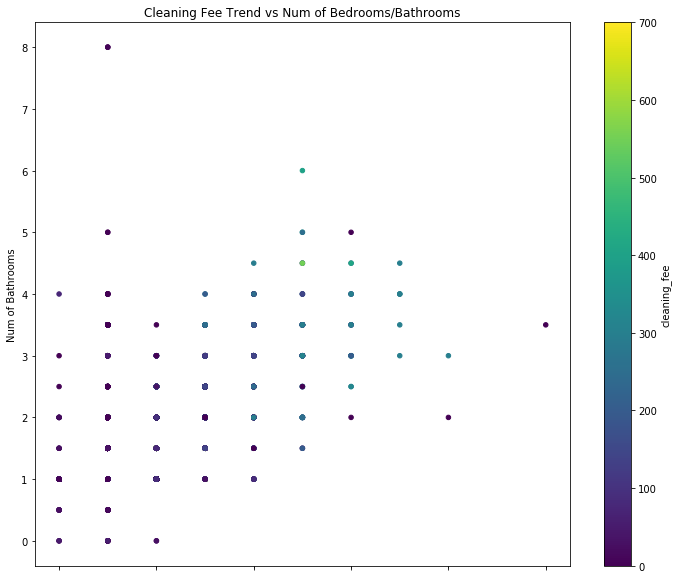

In [110]:
rooms_df = r_cleaned[:][['cleaning_fee','bedrooms','bathrooms']]
rooms_df = rooms_df.dropna()

# Scatter Plot
rooms_df.plot.scatter('bedrooms', 'bathrooms', c='cleaning_fee', cmap='viridis')
plt.xlabel('Num of Bedrooms')
plt.ylabel('Num of Bathrooms')
plt.title('Cleaning Fee Trend vs Num of Bedrooms/Bathrooms')
plt.show()


### Question: Is there any relationship between listing prices and weekly/monthly prices (if applicable)? 
1) Want to identify if any discounts given on weekly or monthly price and if there is a certain pattern


## Analysis on the Host
### Conclusion:
1) After examination of different hosts' attributes against the price, none of the attributes has a significant correlation on the price.

### Analysis Details
1) Build correlations with all host properties against price (assign scores for some categorical data)<BR>
2) The values of interest: <BR>
   a) host_since (if above 0.5 correlation, derive years value and find if above certain value impacts price)<BR>
   b) is_superhost (t - super, f - not)<BR>
   c) host_location (derive numeric scale for in_city, in_state, in_country, out_country)<BR>
   d) host_response_time (convert to numeric scale: <BR>
   e) host_response_rate (remove % sign)<BR>
   f) host_listings_count (above or below certain count will impact price?)<BR>
   g) host_has_profile_pic<BR>
   h) host_identity_verified<BR>

In [111]:
def get_score_loc(value):
   score = 0
   if (value != value):   # If it is Nan, then score is 0
     score = 0
   elif (CURR_CITY in value):
     score = 3
   elif (CURR_STATE in value):
     score = 2
   elif (CURR_COUNTRY in value):
     score = 1
   else:
     score = 0
   return(score)

def get_score_resptime(value):
   score = 0
   if (value != value):   # If it is Nan, then score is 0
     score = 0
   elif ('within an hour' in value):
     score = 4
   elif ('within a few hours' in value):
     score = 3
   elif ('within a day' in value):
     score = 2
   elif ('a few days or more' in value):
     score = 1        
   return(score)

def remove_per_sign(amt):
   if (amt != amt):   # If it is Nan, then score is 0
     return(0)
   else:
     return(float(amt.replace('%', '')))

# 9/28/18: 1) somehow got error "The truth value of a Series is ambiguous." if using one line if-else 
hosts_df = r_cleaned[:][host_data]
hosts_df['host_since_num'] = datetime.datetime.now() - hosts_df['host_since']
hosts_df['host_is_superhost_score'] = np.where(hosts_df['host_is_superhost'] == 't', 1, 0)
#hosts_df['host_is_superhost_val'] = 1 if (hosts_df['host_is_superhost'] == 't') else 0
hosts_df['host_location_score'] = hosts_df['host_location'].apply(get_score_loc)
hosts_df['host_response_time_score'] = hosts_df['host_response_time'].apply(get_score_resptime)
hosts_df['host_response_rate_final'] = hosts_df['host_response_rate'].apply(remove_per_sign)
hosts_df['host_has_profile_pic_score'] = np.where(hosts_df['host_has_profile_pic'] == 't', 1, 0)
hosts_df['host_identity_verified_score'] = np.where(hosts_df['host_identity_verified'] == 't', 1, 0)

#pd.unique(hosts_df['host_response_time_score'])
#pd.unique(hosts_df['host_location_score']) # show unique values
# pd.unique(hosts_df.loc[:, 'host_location']) # show unique values (longer version)


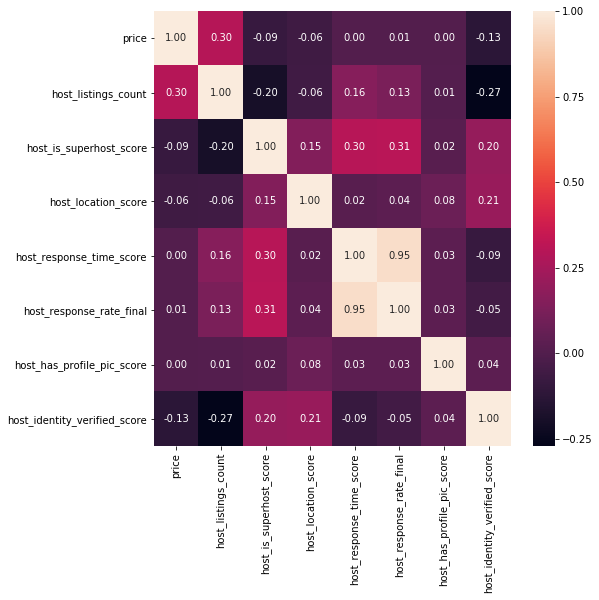

In [112]:
# Analysis on the Host
# List out hosts' Pearson Correlations
hosts_df.corr()

plt.rcParams["figure.figsize"] = [8,8]
sns.heatmap(hosts_df.corr(), annot=True, fmt=".2f")
plt.show()

## Analysis on the Reviews
### Conclusion:
1) After examination of different review attributes against the price, none of the attributes has a significant correlation on the price.

### Analysis Details
1) Build correlations with all host properties against price<BR>
2) The values of interest: (all review_scores_ are numeric values) <BR>
number_of_reviews<BR>
first_review<BR>
last_review<BR>
review_scores_rating<BR>
review_scores_accuracy<BR>
review_scores_cleanliness<BR>
review_scores_checkin<BR>
review_scores_communication<BR>
review_scores_location<BR>
review_scores_value<BR>
reviews_per_month<BR>

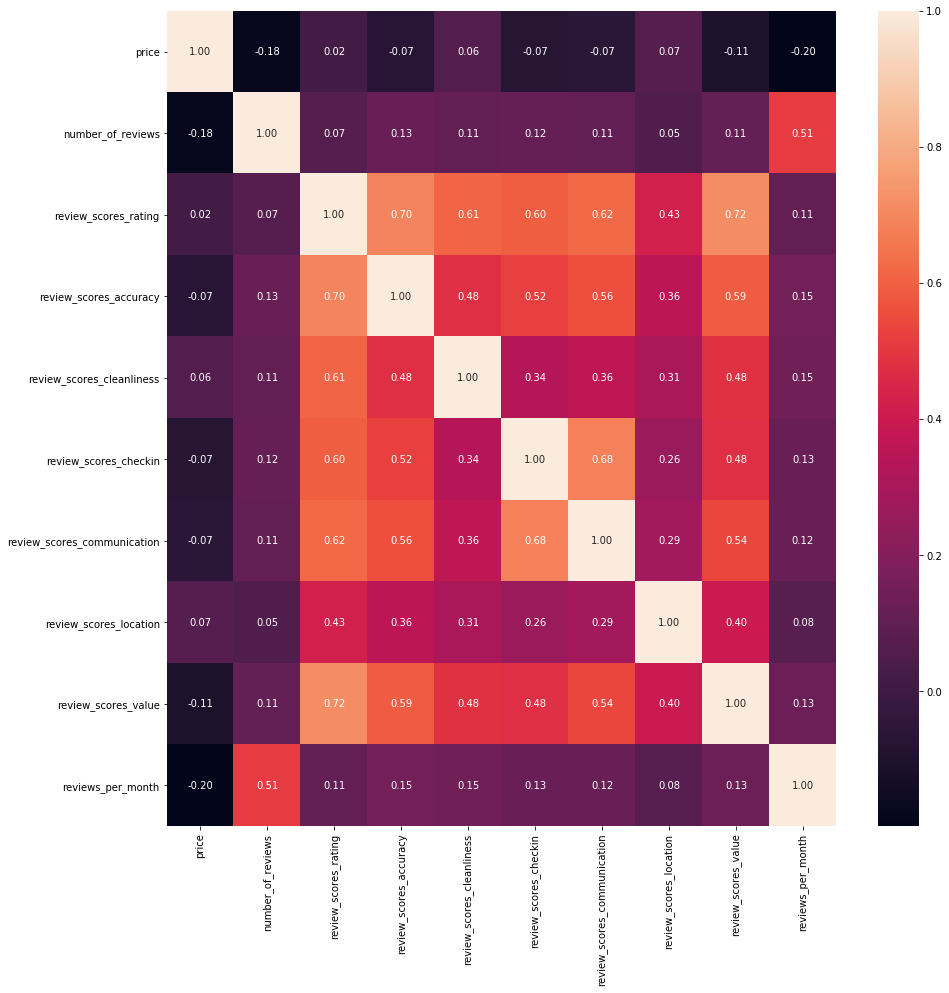

In [113]:
# Fill NaN values with 0
r_listings['review_scores_rating'] = r_listings['review_scores_rating'].fillna('0') 
r_listings['review_scores_accuracy'] = r_listings['review_scores_accuracy'].fillna('0') 
r_listings['review_scores_cleanliness'] = r_listings['review_scores_cleanliness'].fillna('0') 
r_listings['review_scores_checkin'] = r_listings['review_scores_checkin'].fillna('0') 
r_listings['review_scores_communication'] = r_listings['review_scores_communication'].fillna('0') 
r_listings['review_scores_location'] = r_listings['review_scores_location'].fillna('0') 
r_listings['review_scores_value'] = r_listings['review_scores_value'].fillna('0') 
r_listings['reviews_per_month'] = r_listings['reviews_per_month'].fillna('0') 

reviews_df = r_cleaned[:][reviews_data]
reviews_df.corr()

plt.rcParams["figure.figsize"] = [15,15]
sns.heatmap(reviews_df.corr(), annot=True, fmt=".2f")
plt.show()

## Final EDA Observations:
### 1) Seattle listings have mean price around 150 with 75% of listing below 200.
### 2) Location wise, there is a heavy cluster of listings around Capitol Hill area. No specific area stands out as higher-priced area.
### 3) Features wise, it seems price has higher correlations with accommodates, bedrooms and square_feet.
### 4) Policy wise, only cleaning fee seems to have impace on listing price and the fee mostly varies between 0 to 300 over different levels of listing prices.
### 5) Host attributes and Review scores do not seem to have strong correlation with the listing prices